In [1]:
# Import required packages
import matplotlib as mpl
from matplotlib import colors

%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) #this increases the inline figure size to 15 tall x 10 wide

import seaborn
import pandas as pd
import geopandas as gpd
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # Change settings so that warnings are not displayed

import contextily as cx
from shapely.geometry import Polygon
import plotly.express as px
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.moran import Moran_Local

# Loading a few new packages
from scipy import stats
from pysal.model import spreg
import statsmodels.formula.api as sm

C:\Users\lambe\anaconda3\envs\geo_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\lambe\anaconda3\envs\geo_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
hp = gpd.read_file('houses_lr.geojson') 
oa = gpd.read_file('OutputAreas.geojson')
KM0 = gpd.read_file('KM_Zero.geojson')
lb = gpd.read_file('london_boroughs.geojson')

In [3]:
hp.head()

postcode      price dateoftransfer propertytype oldnew duration  \
0   CR53EZ   795000.0     2012-03-15            D      Y        F   
1   CR53EZ  1250000.0     2015-12-18            D      N        F   
2   CR53EZ  1000000.0     2011-12-22            D      Y        F   
3   CR53EZ   970000.0     2015-12-04            D      N        F   
4   CR53EZ   995000.0     2016-10-18            D      N        F   

  categorytype recordstatus    year  tfarea  numberrooms     priceper  \
0            A            A  2012.0   250.0          7.0  3180.000000   
1            A            A  2015.0   279.0          9.0  4480.286738   
2            A            A  2011.0   302.0          9.0  3311.258278   
3            A            A  2015.0   272.0          9.0  3566.176471   
4            A            A  2016.0   288.0          7.0  3454.861111   

       pcd      pcd2    dointr  doterm                       geometry  
0  CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)  
1  CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)  
2  CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)  
3  CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)  
4  CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)

In [4]:
hp16 = hp[(hp["year"]==2016)]

hp16['Detached'] = np.where(hp16['propertytype']=='D', 1, 0)
hp16['Flats'] = np.where(hp16['propertytype']=='F', 1, 0)
hp16['New'] = np.where(hp16['oldnew']=='Y', 1, 0)

hp16.head()

postcode      price dateoftransfer propertytype oldnew duration  \
4    CR53EZ   995000.0     2016-10-18            D      N        F   
23  EC3N1NT  1300000.0     2016-03-31            F      N        L   
33  EC2Y8AU   895000.0     2016-11-25            F      N        L   
34  EC4A4AX   585000.0     2016-10-04            F      N        L   
42  EC2Y8AH   725000.0     2016-03-23            F      N        L   

   categorytype recordstatus    year  tfarea  numberrooms      priceper  \
4             A            A  2016.0   288.0          7.0   3454.861111   
23            A            A  2016.0   140.0          3.0   9285.714286   
33            A            A  2016.0    73.0          3.0  12260.273973   
34            A            A  2016.0    46.0          2.0  12717.391304   
42            A            A  2016.0    64.0          3.0  11328.125000   

        pcd      pcd2    dointr  doterm                       geometry  \
4   CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)   
23  EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   
33  EC2Y8AU  EC2Y 8AU  198001.0     NaN  POINT (532528.000 181795.000)   
34  EC4A4AX  EC4A 4AX  198001.0     NaN  POINT (531576.000 181225.000)   
42  EC2Y8AH  EC2Y 8AH  198301.0     NaN  POINT (532228.000 181982.000)   

    Detached  Flats  New  
4          1      0    0  
23         0      1    0  
33         0      1    0  
34         0      1    0  
42         0      1    0

In [ ]:
lb.head()

In [37]:
sch = pd.read_csv('Londonallschools_2016.csv')

In [38]:
sch.head()

OBJECTID     URN                                         SCHOOL_NAM  \
0        1  135155                        Ayesha Siddiqa Girls School   
1        2  140492                                 Beis Medrash Elyon   
2        3  141411                    Big Creative Independent School   
3        4  142336                             Wetherby Senior School   
4        5  100042  St Mary's Kilburn Church of England Primary Sc...   

                       TYPE           PHASE                   ADDRESS  \
0  Other Independent School  Not applicable      165-169 The Broadway   
1  Other Independent School  Not applicable  233 West Hendon Broadway   
2  Other Independent School  Not applicable        Silver Birch House   
3  Other Independent School  Not applicable       100 Marylebone Lane   
4    Voluntary Aided School         Primary                 Quex Road   

          TOWN POSTCODE GENDER               WARD_NAME            LSOA_NAME  \
0     Southall  UB1 1LR  Girls       Southall Broadway          Ealing 026C   
1       London  NW9 7DG   Boys             West Hendon          Barnet 036F   
2  Walthamstow  E17 5SD  Mixed             Higham Hill  Waltham Forest 014C   
3       London  W1U 2QB   Boys  Marylebone High Street     Westminster 011B   
4       London  NW6 4PG  Mixed                 Kilburn          Camden 020C   

          LA_NAME  Primary         x          y  
0          Ealing        0 -0.378496  51.507500  
1          Barnet        0 -0.241628  51.578999  
2  Waltham Forest        0 -0.042590  51.594002  
3     Westminster        0 -0.150409  51.517601  
4          Camden        1 -0.193367  51.540402

In [39]:
sch2 = gpd.GeoDataFrame(
    sch, geometry=gpd.points_from_xy(x= sch.x, y= sch.y)
)
sch2.crs = lb.crs

In [40]:
sch2.head()

OBJECTID     URN                                         SCHOOL_NAM  \
0        1  135155                        Ayesha Siddiqa Girls School   
1        2  140492                                 Beis Medrash Elyon   
2        3  141411                    Big Creative Independent School   
3        4  142336                             Wetherby Senior School   
4        5  100042  St Mary's Kilburn Church of England Primary Sc...   

                       TYPE           PHASE                   ADDRESS  \
0  Other Independent School  Not applicable      165-169 The Broadway   
1  Other Independent School  Not applicable  233 West Hendon Broadway   
2  Other Independent School  Not applicable        Silver Birch House   
3  Other Independent School  Not applicable       100 Marylebone Lane   
4    Voluntary Aided School         Primary                 Quex Road   

          TOWN POSTCODE GENDER               WARD_NAME            LSOA_NAME  \
0     Southall  UB1 1LR  Girls       Southall Broadway          Ealing 026C   
1       London  NW9 7DG   Boys             West Hendon          Barnet 036F   
2  Walthamstow  E17 5SD  Mixed             Higham Hill  Waltham Forest 014C   
3       London  W1U 2QB   Boys  Marylebone High Street     Westminster 011B   
4       London  NW6 4PG  Mixed                 Kilburn          Camden 020C   

          LA_NAME  Primary         x          y                   geometry  
0          Ealing        0 -0.378496  51.507500  POINT (-0.37850 51.50750)  
1          Barnet        0 -0.241628  51.578999  POINT (-0.24163 51.57900)  
2  Waltham Forest        0 -0.042590  51.594002  POINT (-0.04259 51.59400)  
3     Westminster        0 -0.150409  51.517601  POINT (-0.15041 51.51760)  
4          Camden        1 -0.193367  51.540402  POINT (-0.19337 51.54040)

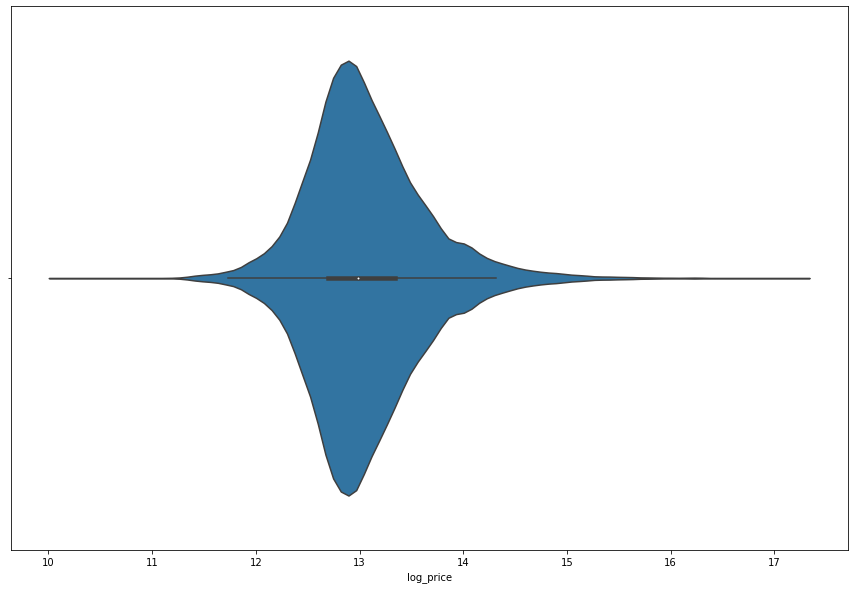

In [10]:
hp16['log_area'] = np.log(hp16['tfarea'])
hp16['log_price'] = np.log(hp16['price'])
bx = seaborn.violinplot(x=hp16["log_price"])

In [12]:
variable_names = ['log_area', 'numberrooms', 'Flats', 'Detached','New']

In [13]:
m1 = spreg.OLS(hp16[['log_price']].values, hp16[variable_names].values,
                name_y='log_price', name_x=variable_names, robust='white')
print(m1.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       70925
Mean dependent var  :     13.0566                Number of Variables   :           6
S.D. dependent var  :      0.5740                Degrees of Freedom    :       70919
R-squared           :      0.5122
Adjusted R-squared  :      0.5122
Sum squared residual:   11399.778                F-statistic           :  14894.2533
Sigma-square        :       0.161                Prob(F-statistic)     :           0
S.E. of regression  :       0.401                Log likelihood        :  -35811.733
Sigma-square ML     :       0.161                Akaike info criterion :   71635.465
S.E of regression ML:      0.4009                Schwarz criterion     :   71690.482

White Standard Errors
-------------------------------------------------------

In [16]:
variable_names2 = ['log_area', 'numberrooms', 'Flats','New']

In [18]:
m2 = spreg.OLS(hp16[['log_price']].values, hp16[variable_names2].values,
                name_y='log_price', name_x=variable_names2, robust='white')
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       70925
Mean dependent var  :     13.0566                Number of Variables   :           5
S.D. dependent var  :      0.5740                Degrees of Freedom    :       70920
R-squared           :      0.5122
Adjusted R-squared  :      0.5122
Sum squared residual:   11400.177                F-statistic           :  18616.8057
Sigma-square        :       0.161                Prob(F-statistic)     :           0
S.E. of regression  :       0.401                Log likelihood        :  -35812.975
Sigma-square ML     :       0.161                Akaike info criterion :   71635.950
S.E of regression ML:      0.4009                Schwarz criterion     :   71681.797

White Standard Errors
-------------------------------------------------------

In [19]:
np.exp(0.0102887) - 1 # every time the number of rooms increase one, the house of price increase 1.03%

0.010341810664130424

In [20]:
np.exp(0.1720129) - 1 #  we're predicting a 18.8% higher (geometric average) housing price for flats compared to all other types,

0.18769315435677547

In [21]:
(1.1)**0.9989738 - 1 # We expect a 9.99% increase in housing price when housing size increases by 10%

0.0998924172241098

So we expect to see a 9.99% increase in housing price for every 10% increase in housing size.

In [23]:
hp16_2 = gpd.sjoin(hp16,oa)
pd.set_option('display.max_columns', None)
hp16_2.head()

postcode      price dateoftransfer propertytype oldnew duration  \
4        CR53EZ   995000.0     2016-10-18            D      N        F   
141027   CR53EH   720000.0     2016-02-10            D      N        F   
149022   CR53EQ   535000.0     2016-03-30            T      N        F   
23      EC3N1NT  1300000.0     2016-03-31            F      N        L   
550     EC3N1NT   680000.0     2016-07-20            F      N        L   

       categorytype recordstatus    year  tfarea  numberrooms     priceper  \
4                 A            A  2016.0   288.0          7.0  3454.861111   
141027            A            A  2016.0   141.4          7.0  5091.937765   
149022            A            A  2016.0   143.0          6.0  3741.258741   
23                A            A  2016.0   140.0          3.0  9285.714286   
550               A            A  2016.0    84.0          3.0  8095.238095   

            pcd      pcd2    dointr  doterm                       geometry  \
4       CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)   
141027  CR5 3EH  CR5  3EH  199007.0     NaN  POINT (529109.000 157935.000)   
149022  CR5 3EQ  CR5  3EQ  200703.0     NaN  POINT (529166.000 157845.000)   
23      EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   
550     EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   

        Detached  Flats  New  log_area  log_price  index_right   geo_code  \
4              1      0    0  5.662960  13.810498        19031  E00005097   
141027         1      0    0  4.951593  13.487006        19031  E00005097   
149022         0      0    0  4.962845  13.190022        19031  E00005097   
23             0      1    0  4.941642  14.077875        12112  E00000029   
550            0      1    0  4.430817  13.429848        12112  E00000029   

                              label          NAME_2    POP    POPDENS     HH  \
4       E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
141027  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
149022  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
23      E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   
550     E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   

        HECTARES    DEPRHH EMPRES   STUDENT   PROFSCI  Trees  TreeDens  
4          60.26  0.375940    197  0.062914  0.127451   21.0  0.348490  
141027     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490  
149022     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490  
23         15.31  0.740157    125  0.095000  0.136364  110.0  7.184847  
550        15.31  0.740157    125  0.095000  0.136364  110.0  7.184847

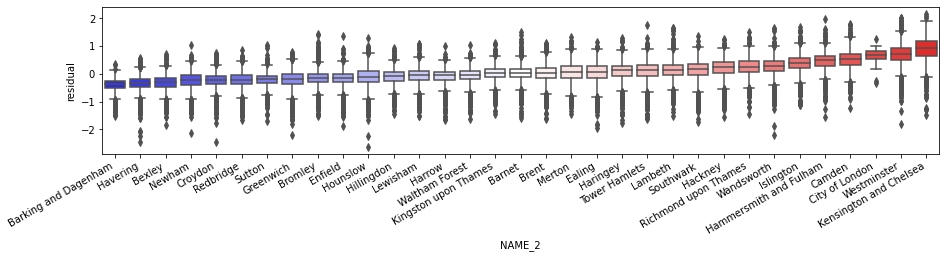

In [32]:
hp16_2['residual'] = m1.u
medians = hp16_2.groupby("NAME_2").residual.median().to_frame('hood_residual')

f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot('NAME_2', 'residual', ax = ax,
                data=hp16_2.merge(medians, how='left',
                              left_on='NAME_2',
                              right_index=True)
                   .sort_values('hood_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

In [33]:
w = weights.DistanceBand.from_dataframe(hp16_2, 500)

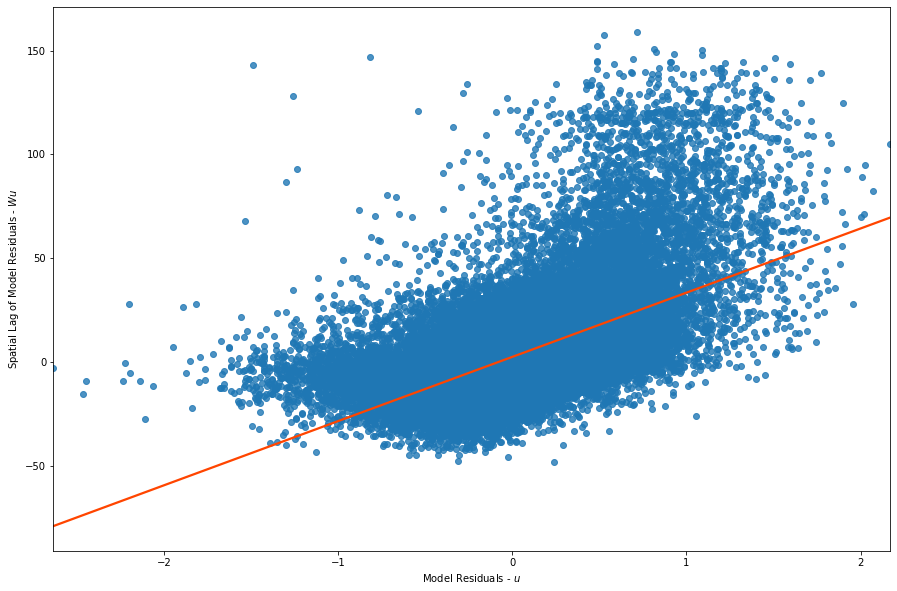

In [34]:
lag_residual = weights.spatial_lag.lag_spatial(w, m1.u)
ax = seaborn.regplot(m1.u.flatten(), lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

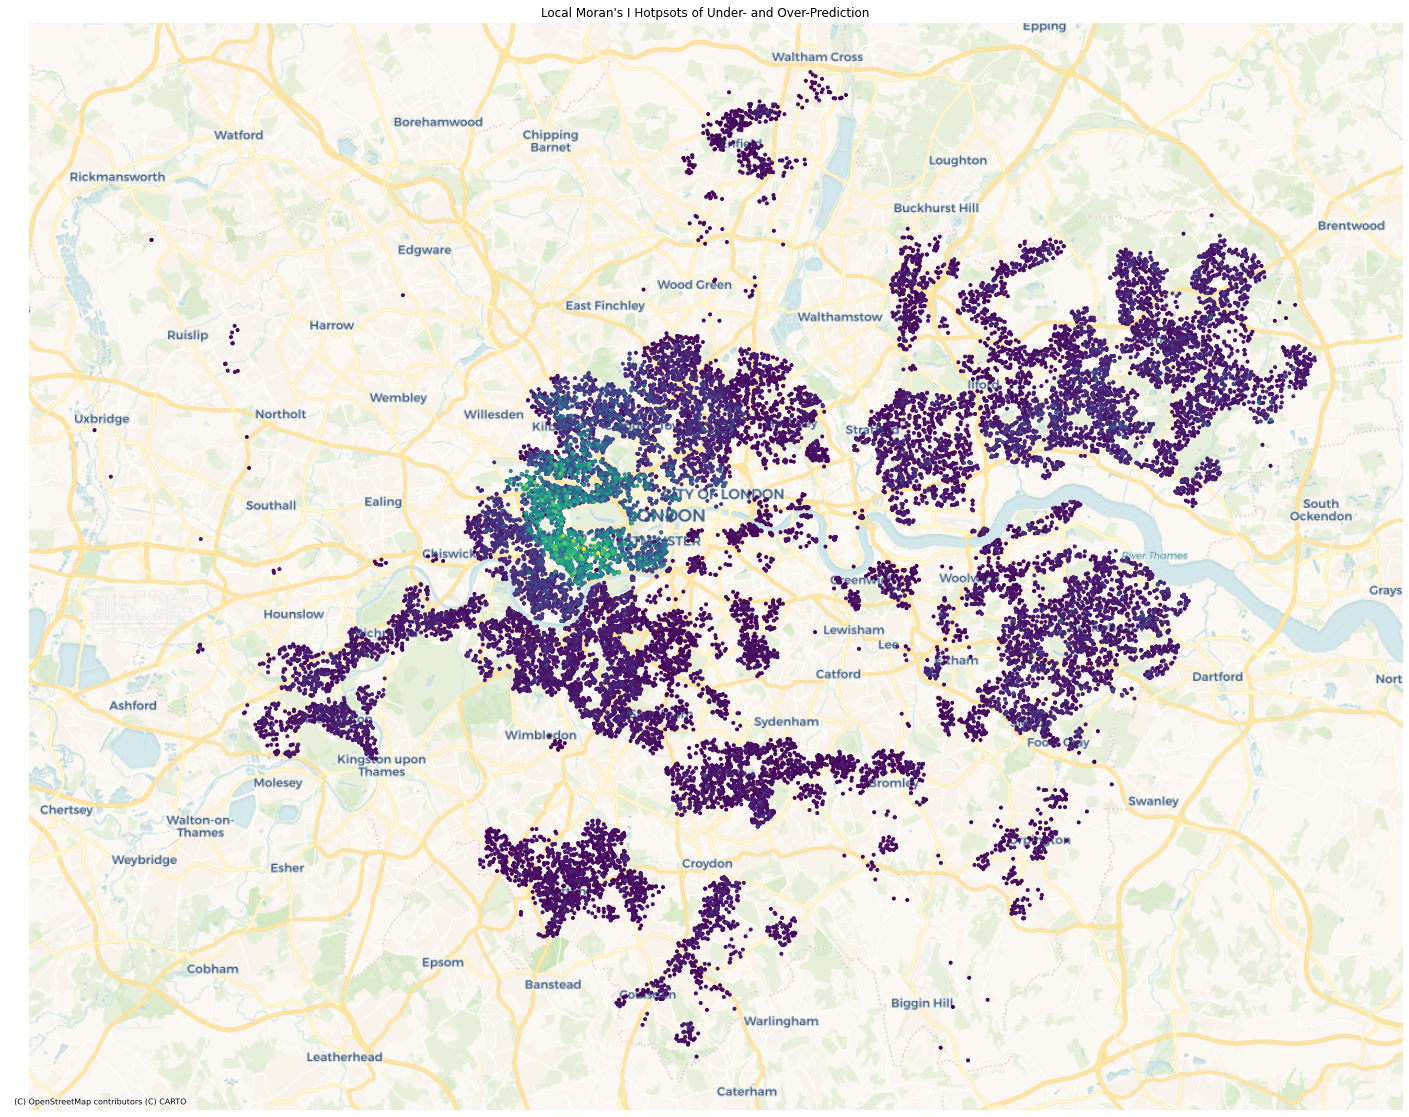

In [36]:
outliers = esda.moran.Moran_Local(m1.u, w, permutations=999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
f, ax = plt.subplots(1, figsize=(25, 20)) #Subplots allows you to draw multiple plots in one figure
hp16_2.assign(error_clusters = error_clusters,
          local_I = outliers.Is)\
  .query("error_clusters")\
  .sort_values('local_I')\
  .to_crs('EPSG:3857').plot('local_I', cmap='viridis', marker='.', ax=ax)
ax.set_title("Local Moran's I Hotpsots of Under- and Over-Prediction")
ax.set_axis_off() #Remove axes from plot 
plt.axis('equal') #Set x and y axes to be equal size
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

In [ ]:
hp16_2.assign(error_clusters = error_clusters,
          local_I = outliers.Is)\
  .query("error_clusters")\
  .sort_values('local_I')\
  .to_crs('EPSG:3857').plot('local_I', cmap='viridis', marker='.', ax=ax)
ax.set_title("Local Moran's I Hotpsots of Under- and Over-Prediction")
ax.set_axis_off() #Remove axes from plot 
plt.axis('equal') #Set x and y axes to be equal size
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

In [111]:
sch_primary = sch2[sch2['Primary']==1]
sch_sec = sch2[sch2['PHASE']=='Secondary']

sch_sec

OBJECTID     URN                             SCHOOL_NAM  \
14          15  134222     City of London Academy (Southwark)   
15          16  137009             Rivers Academy West London   
17          18  140957      Eden Girls' School Waltham Forest   
1076  1,077.00  100049                      Haverstock School   
1077  1,078.00  100050                 Parliament Hill School   
...        ...     ...                                    ...   
3823  3,824.00  142051                    Haileybury Turnford   
3830  3,831.00  142126               Space Studio West London   
3849  3,850.00  142315                           Oxted School   
3857  3,858.00  142560  St Gregory's Catholic Science College   
3874  3,875.00  102047                       Southgate School   

                     TYPE      PHASE             ADDRESS           TOWN  \
14    Academy Sponsor Led  Secondary     240 Lynton Road         London   
15      Academy Converter  Secondary      Tachbrook Road        Feltham   
17           Free Schools  Secondary  Silver Birch House    Walthanstow   
1076     Community School  Secondary  24 Haverstock Hill         London   
1077     Community School  Secondary       Highgate Road         London   
...                   ...        ...                 ...            ...   
3823  Academy Sponsor Led  Secondary           Mill Lane  Waltham Cross   
3830       Studio Schools  Secondary   Letchworth Avenue       Hounslow   
3849    Academy Converter  Secondary      Bluehouse Lane          Oxted   
3857    Academy Converter  Secondary     Donnington Road         Harrow   
3874     Community School  Secondary          Sussex Way         Barnet   

      POSTCODE GENDER                  WARD_NAME            LSOA_NAME  \
14     SE1 5LA  Mixed           South Bermondsey       Southwark 010C   
15    TW14 9PD  Mixed              Feltham North        Hounslow 022C   
17     E17 5QJ  Girls                Higham Hill  Waltham Forest 014C   
1076   NW3 2BQ  Mixed                 Haverstock          Camden 012D   
1077   NW5 1RL  Girls                   Highgate          Camden 001D   
...        ...    ...                        ...                  ...   
3823   EN8 0JU  Mixed             Cheshunt North      Broxbourne 008A   
3830  TW14 9PE  Mixed              Feltham North        Hounslow 022C   
3849   RH8 0AB  Mixed  Oxted North and Tandridge       Tandridge 006C   
3857   HA3 0NB  Mixed                     Kenton           Brent 004B   
3874   EN4 0BL  Mixed                Cockfosters         Enfield 011C   

             LA_NAME  Primary         x          y                   geometry  
14         Southwark        0 -0.065904  51.488998  POINT (-0.06590 51.48900)  
15          Hounslow        0 -0.420888  51.452900  POINT (-0.42089 51.45290)  
17    Waltham Forest        0 -0.042590  51.594002  POINT (-0.04259 51.59400)  
1076          Camden        0 -0.153242  51.544800  POINT (-0.15324 51.54480)  
1077          Camden        0 -0.149660  51.558498  POINT (-0.14966 51.55850)  
...              ...      ...       ...        ...                        ...  
3823      Broxbourne        0 -0.026346  51.711800  POINT (-0.02635 51.71180)  
3830        Hounslow        0 -0.420888  51.452900  POINT (-0.42089 51.45290)  
3849       Tandridge        0 -0.001621  51.260201  POINT (-0.00162 51.26020)  
3857           Brent        0 -0.304770  51.583698  POINT (-0.30477 51.58370)  
3874         Enfield        0 -0.140749  51.647098  POINT (-0.14075 51.64710)  

[495 rows x 16 columns]

In [112]:
sch_primary

OBJECTID     URN                                         SCHOOL_NAM  \
4            5  100042  St Mary's Kilburn Church of England Primary Sc...   
5            6  100224                         De Beauvoir Primary School   
6            7  100235                        Queensbridge Primary School   
7            8  100239                        Princess May Primary School   
8            9  100263      Holy Trinity Church of England Primary School   
...        ...     ...                                                ...   
3883  3,884.00  131750                           Claremont Primary School   
3884  3,885.00  131846                             Portway Primary School   
3885  3,886.00  132008                                     Burwood School   
3887  3,888.00  133525                            Mayville Primary School   
3888  3,889.00  134449                            Davidson Primary School   

                          TYPE           PHASE            ADDRESS       TOWN  \
4       Voluntary Aided School         Primary          Quex Road     London   
5             Community School         Primary  80 Tottenham Road     London   
6             Community School         Primary  Queensbridge Road     London   
7             Community School         Primary  Princess May Road     London   
8       Voluntary Aided School         Primary      Richmond Road     London   
...                        ...             ...                ...        ...   
3883          Community School         Primary     Claremont Road     London   
3884          Community School         Primary     Stratford Road     London   
3885  Community Special School  Not applicable        Avalon Road  Orpington   
3887          Community School         Primary     Lincoln Street     London   
3888          Community School         Primary      Dartnell Road    Croydon   

     POSTCODE GENDER                WARD_NAME            LSOA_NAME  \
4     NW6 4PG  Mixed                  Kilburn          Camden 020C   
5      N1 4BS  Mixed              De Beauvoir         Hackney 021E   
6      E8 3ND  Mixed             Queensbridge         Hackney 020E   
7     N16 8AJ  Mixed  Stoke Newington Central         Hackney 014F   
8      E8 3DY  Mixed             Queensbridge         Hackney 021I   
...       ...    ...                      ...                  ...   
3883  NW2 1AB  Mixed            Golders Green          Barnet 039C   
3884  E13 0JW  Mixed           Plaistow North          Newham 021A   
3885  BR6 9BD   Boys                Orpington         Bromley 032A   
3887  E11 4PZ  Mixed                  Cathall  Waltham Forest 027F   
3888  CR0 6JA  Mixed               Addiscombe         Croydon 017C   

             LA_NAME  Primary         x          y                   geometry  
4             Camden        1 -0.193367  51.540402  POINT (-0.19337 51.54040)  
5            Hackney        1 -0.077000  51.545299  POINT (-0.07700 51.54530)  
6            Hackney        1 -0.071761  51.539299  POINT (-0.07176 51.53930)  
7            Hackney        1 -0.077609  51.552799  POINT (-0.07761 51.55280)  
8            Hackney        1 -0.073519  51.542702  POINT (-0.07352 51.54270)  
...              ...      ...       ...        ...                        ...  
3883          Barnet        1 -0.217671  51.565700  POINT (-0.21767 51.56570)  
3884          Newham        1  0.017841  51.533901   POINT (0.01784 51.53390)  
3885         Bromley        1  0.117722  51.369999   POINT (0.11772 51.37000)  
3887  Waltham Forest        1  0.006027  51.560001   POINT (0.00603 51.56000)  
3888         Croydon        1 -0.080438  51.384300  POINT (-0.08044 51.38430)  

[2804 rows x 16 columns]

In [105]:
hp16p = hp16.geometry.apply(lambda x: sch_primary.distance(x).min()) # distance to primary

In [106]:
hp16sec = hp16.geometry.apply(lambda x : sch_sec.distance(x).min()) # distance to secondary 

In [108]:
hp16p.tail()

641131    556734.462058
641142    557679.150631
641145    556031.087700
641168    575685.957781
641173    544426.441587
Name: geometry, dtype: float64

In [109]:
hp16sec.tail()

641131    556734.491824
641142    557679.180514
641145    556031.117584
641168    575685.987423
641173    544426.470669
Name: geometry, dtype: float64

In [81]:
hp16dis_sch = pd.merge(hp16_2, hp16p, left_index=True, right_index=True)
hp16dis_sch.head()

postcode      price dateoftransfer propertytype oldnew duration  \
4        CR53EZ   995000.0     2016-10-18            D      N        F   
141027   CR53EH   720000.0     2016-02-10            D      N        F   
149022   CR53EQ   535000.0     2016-03-30            T      N        F   
23      EC3N1NT  1300000.0     2016-03-31            F      N        L   
550     EC3N1NT   680000.0     2016-07-20            F      N        L   

       categorytype recordstatus    year  tfarea  numberrooms     priceper  \
4                 A            A  2016.0   288.0          7.0  3454.861111   
141027            A            A  2016.0   141.4          7.0  5091.937765   
149022            A            A  2016.0   143.0          6.0  3741.258741   
23                A            A  2016.0   140.0          3.0  9285.714286   
550               A            A  2016.0    84.0          3.0  8095.238095   

            pcd      pcd2    dointr  doterm                     geometry_x  \
4       CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)   
141027  CR5 3EH  CR5  3EH  199007.0     NaN  POINT (529109.000 157935.000)   
149022  CR5 3EQ  CR5  3EQ  200703.0     NaN  POINT (529166.000 157845.000)   
23      EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   
550     EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   

        Detached  Flats  New  log_area  log_price  index_right   geo_code  \
4              1      0    0  5.662960  13.810498        19031  E00005097   
141027         1      0    0  4.951593  13.487006        19031  E00005097   
149022         0      0    0  4.962845  13.190022        19031  E00005097   
23             0      1    0  4.941642  14.077875        12112  E00000029   
550            0      1    0  4.430817  13.429848        12112  E00000029   

                              label          NAME_2    POP    POPDENS     HH  \
4       E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
141027  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
149022  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
23      E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   
550     E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   

        HECTARES    DEPRHH EMPRES   STUDENT   PROFSCI  Trees  TreeDens  \
4          60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
141027     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
149022     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
23         15.31  0.740157    125  0.095000  0.136364  110.0  7.184847   
550        15.31  0.740157    125  0.095000  0.136364  110.0  7.184847   

        residual     geometry_y  
4      -0.500676  551994.217827  
141027  0.365783  552162.237540  
149022  0.642484  552191.132933  
23      0.688242  563475.204299  
550     0.563169  563475.204299

In [83]:
hp16dis_sch = pd.merge(hp16dis_sch, hp16sec, left_index=True, right_index=True)
hp16dis_sch.head()

postcode      price dateoftransfer propertytype oldnew duration  \
4        CR53EZ   995000.0     2016-10-18            D      N        F   
141027   CR53EH   720000.0     2016-02-10            D      N        F   
149022   CR53EQ   535000.0     2016-03-30            T      N        F   
23      EC3N1NT  1300000.0     2016-03-31            F      N        L   
550     EC3N1NT   680000.0     2016-07-20            F      N        L   

       categorytype recordstatus    year  tfarea  numberrooms     priceper  \
4                 A            A  2016.0   288.0          7.0  3454.861111   
141027            A            A  2016.0   141.4          7.0  5091.937765   
149022            A            A  2016.0   143.0          6.0  3741.258741   
23                A            A  2016.0   140.0          3.0  9285.714286   
550               A            A  2016.0    84.0          3.0  8095.238095   

            pcd      pcd2    dointr  doterm                     geometry_x  \
4       CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)   
141027  CR5 3EH  CR5  3EH  199007.0     NaN  POINT (529109.000 157935.000)   
149022  CR5 3EQ  CR5  3EQ  200703.0     NaN  POINT (529166.000 157845.000)   
23      EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   
550     EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   

        Detached  Flats  New  log_area  log_price  index_right   geo_code  \
4              1      0    0  5.662960  13.810498        19031  E00005097   
141027         1      0    0  4.951593  13.487006        19031  E00005097   
149022         0      0    0  4.962845  13.190022        19031  E00005097   
23             0      1    0  4.941642  14.077875        12112  E00000029   
550            0      1    0  4.430817  13.429848        12112  E00000029   

                              label          NAME_2    POP    POPDENS     HH  \
4       E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
141027  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
149022  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
23      E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   
550     E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   

        HECTARES    DEPRHH EMPRES   STUDENT   PROFSCI  Trees  TreeDens  \
4          60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
141027     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
149022     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
23         15.31  0.740157    125  0.095000  0.136364  110.0  7.184847   
550        15.31  0.740157    125  0.095000  0.136364  110.0  7.184847   

        residual     geometry_y       geometry  
4      -0.500676  551994.217827  551994.248776  
141027  0.365783  552162.237540  552162.268493  
149022  0.642484  552191.132933  552191.163890  
23      0.688242  563475.204299  563475.234289  
550     0.563169  563475.204299  563475.234289

In [116]:
hp16dis_sch = hp16dis_sch.rename(index=str, columns={"geometry_y":"Dist_primary", "geometry_x":"geometry",'geometry':'Dist_secondary'})

In [ ]:
hp16dis_sch2 = 

In [90]:
hp16dis_sch.head()

postcode      price dateoftransfer propertytype oldnew duration  \
4        CR53EZ   995000.0     2016-10-18            D      N        F   
141027   CR53EH   720000.0     2016-02-10            D      N        F   
149022   CR53EQ   535000.0     2016-03-30            T      N        F   
23      EC3N1NT  1300000.0     2016-03-31            F      N        L   
550     EC3N1NT   680000.0     2016-07-20            F      N        L   

       categorytype recordstatus    year  tfarea  numberrooms     priceper  \
4                 A            A  2016.0   288.0          7.0  3454.861111   
141027            A            A  2016.0   141.4          7.0  5091.937765   
149022            A            A  2016.0   143.0          6.0  3741.258741   
23                A            A  2016.0   140.0          3.0  9285.714286   
550               A            A  2016.0    84.0          3.0  8095.238095   

            pcd      pcd2    dointr  doterm                       geometry  \
4       CR5 3EZ  CR5  3EZ  201107.0     NaN  POINT (528925.000 157964.000)   
141027  CR5 3EH  CR5  3EH  199007.0     NaN  POINT (529109.000 157935.000)   
149022  CR5 3EQ  CR5  3EQ  200703.0     NaN  POINT (529166.000 157845.000)   
23      EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   
550     EC3N1NT  EC3N 1NT  198001.0     NaN  POINT (533634.000 180992.000)   

        Detached  Flats  New  log_area  log_price  index_right   geo_code  \
4              1      0    0  5.662960  13.810498        19031  E00005097   
141027         1      0    0  4.951593  13.487006        19031  E00005097   
149022         0      0    0  4.962845  13.190022        19031  E00005097   
23             0      1    0  4.941642  14.077875        12112  E00000029   
550            0      1    0  4.430817  13.429848        12112  E00000029   

                              label          NAME_2    POP    POPDENS     HH  \
4       E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
141027  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
149022  E92000001E09000008E00005097         Croydon  399.0   6.621308  133.0   
23      E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   
550     E92000001E41000324E00000029  City of London  225.0  14.696280  127.0   

        HECTARES    DEPRHH EMPRES   STUDENT   PROFSCI  Trees  TreeDens  \
4          60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
141027     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
149022     60.26  0.375940    197  0.062914  0.127451   21.0  0.348490   
23         15.31  0.740157    125  0.095000  0.136364  110.0  7.184847   
550        15.31  0.740157    125  0.095000  0.136364  110.0  7.184847   

        residual  Dist_primary  Dist_secondary  
4      -0.500676    551.994218      551.994249  
141027  0.365783    552.162238      552.162268  
149022  0.642484    552.191133      552.191164  
23      0.688242    563.475204      563.475234  
550     0.563169    563.475204      563.475234

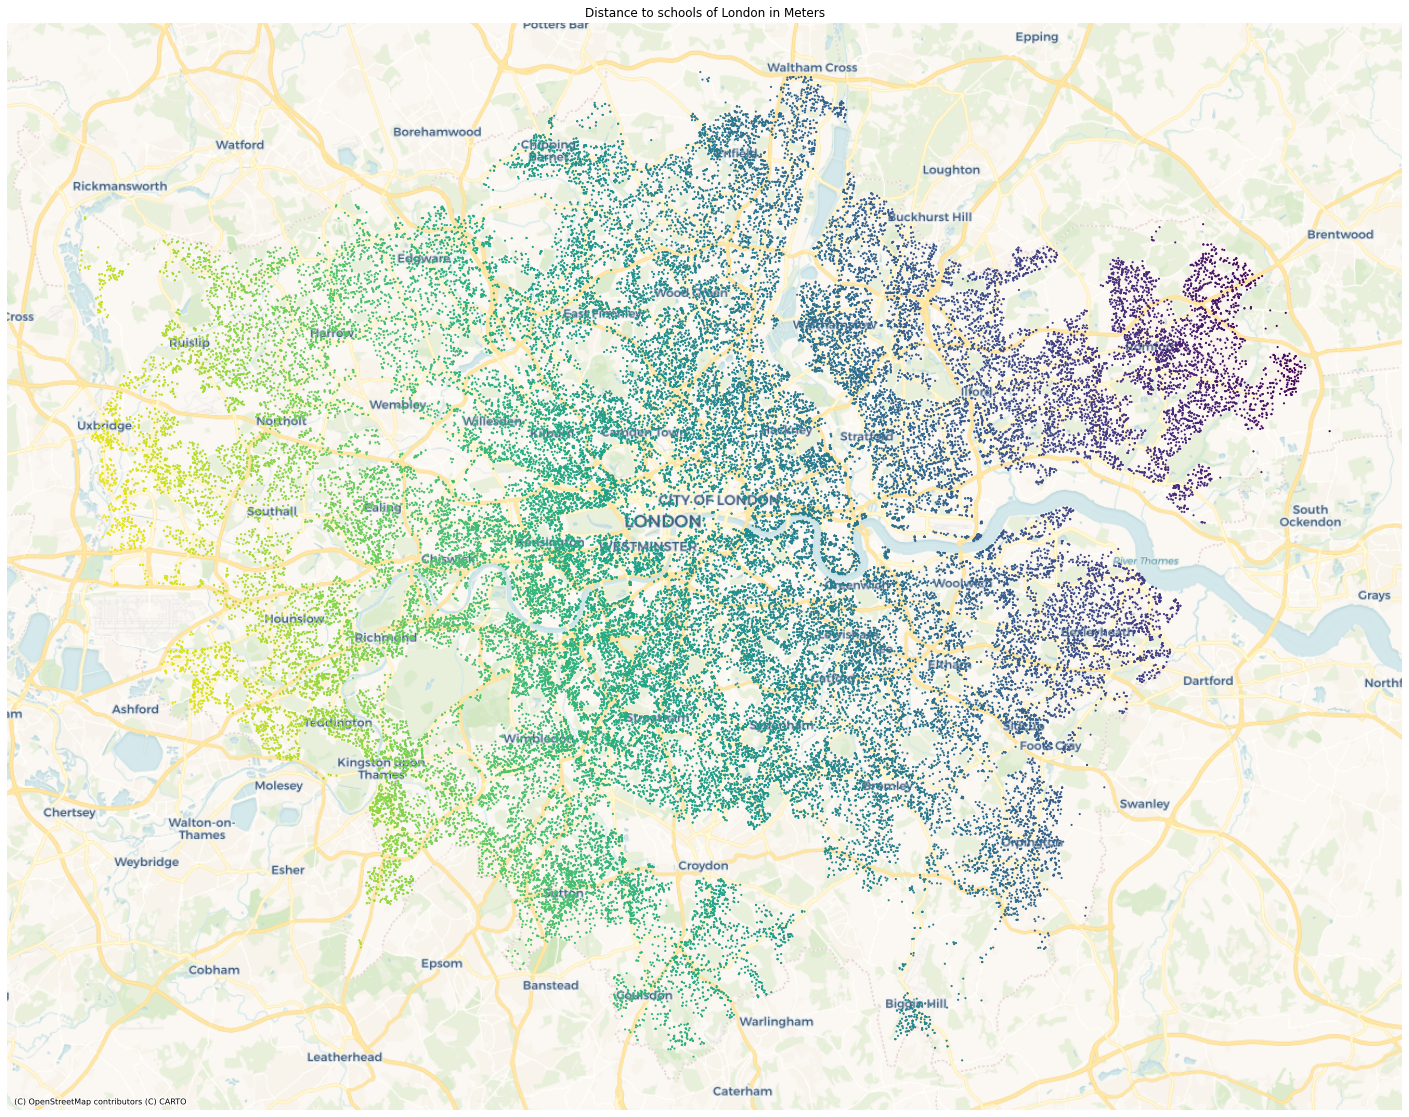

In [91]:
color_map = plt.cm.get_cmap('viridis')
reversed_color_map = color_map.reversed()
f, ax = plt.subplots(1, figsize=(25, 20)) #Subplots allows you to draw multiple plots in one figure
hp16dis_sch.to_crs('EPSG:3857').plot('Dist_primary', cmap=reversed_color_map, marker='.', s=5, ax=ax)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('Distance to schools of London in Meters') #Plot title text
plt.axis('equal') #Set x and y axes to be equal size
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

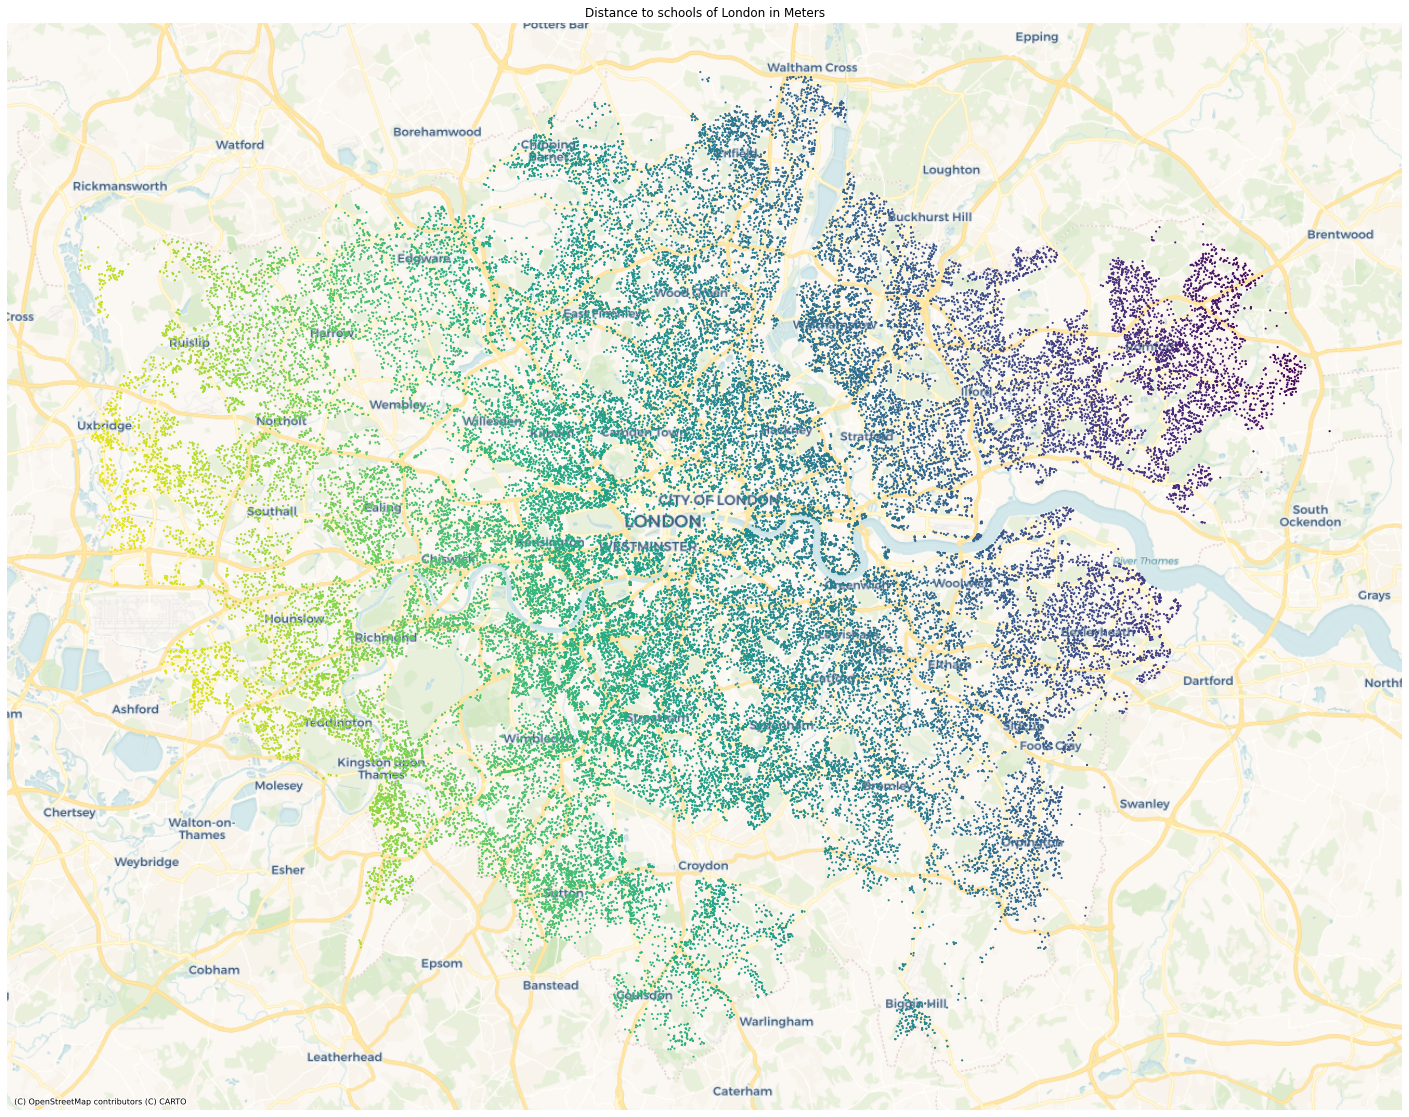

In [92]:
color_map = plt.cm.get_cmap('viridis')
reversed_color_map = color_map.reversed()
f, ax = plt.subplots(1, figsize=(25, 20)) #Subplots allows you to draw multiple plots in one figure
hp16dis_sch.to_crs('EPSG:3857').plot('Dist_secondary', cmap=reversed_color_map, marker='.', s=5, ax=ax)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('Distance to schools of London in Meters') #Plot title text
plt.axis('equal') #Set x and y axes to be equal size
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

In [119]:
dist_names = variable_names2 + ['Dist_primary']
dist_names

['log_area', 'numberrooms', 'Flats', 'New', 'Dist_primary']

In [120]:
m3 = spreg.OLS(hp16dis_sch[['log_price']].values, hp16dis_sch[dist_names].values,
                name_y = 'log_price', name_x = dist_names, robust='white')
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       70925
Mean dependent var  :     13.0566                Number of Variables   :           6
S.D. dependent var  :      0.5740                Degrees of Freedom    :       70919
R-squared           :      0.5509
Adjusted R-squared  :      0.5508
Sum squared residual:   10496.422                F-statistic           :  17396.8028
Sigma-square        :       0.148                Prob(F-statistic)     :           0
S.E. of regression  :       0.385                Log likelihood        :  -32883.970
Sigma-square ML     :       0.148                Akaike info criterion :   65779.941
S.E of regression ML:      0.3847                Schwarz criterion     :   65834.957

White Standard Errors
-------------------------------------------------------

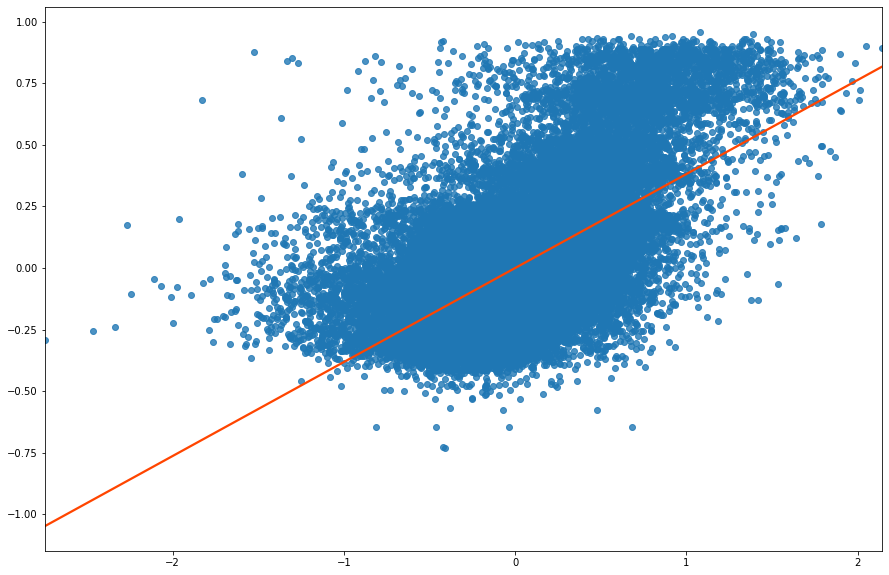

In [97]:
lag_residual = weights.spatial_lag.lag_spatial(w, m3.u)
seaborn.regplot(m3.u.flatten(), lag_residual.flatten(), 
                line_kws=dict(color='orangered'),
                ci=None);

<h1>Spatial Regression Specifications</h1>

Spatial Diagnostics 空间诊断学

In [121]:
m4 = spreg.OLS(hp16dis_sch[['log_price']].values, hp16dis_sch[dist_names].values,
                name_y='log_price', name_x=dist_names, robust='white', w=w, spat_diag=True, moran=True)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       70925
Mean dependent var  :     13.0566                Number of Variables   :           6
S.D. dependent var  :      0.5740                Degrees of Freedom    :       70919
R-squared           :      0.5509
Adjusted R-squared  :      0.5508
Sum squared residual:   10496.422                F-statistic           :  17396.8028
Sigma-square        :       0.148                Prob(F-statistic)     :           0
S.E. of regression  :       0.385                Log likelihood        :  -32883.970
Sigma-square ML     :       0.148                Akaike info criterion :   65779.941
S.E of regression ML:      0.3847                Schwarz criterion     :   65834.957

White Standard Errors
-------------------------------------------------------

In [67]:
m5 = spreg.GM_Lag(hp16dis_sch[['log_price']].values, hp16dis_sch[dist_names].values,
                     w=w, name_y='log_price', name_x=dist_names, robust='white')
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       70925
Mean dependent var  :     13.0566                Number of Variables   :           7
S.D. dependent var  :      0.5740                Degrees of Freedom    :       70918
Pseudo R-squared    :      0.6224
Spatial Pseudo R-squared:  0.5191

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       8.2882677       0.6539511      12.6741407       0.0000000
            log_area       0.9227893       0.0099720      92.5377594       0.0000000
         numberrooms       0.0109713 

In [68]:
m6 = spreg.GM_Error_Het(hp16dis_sch[['log_price']].values, hp16dis_sch[dist_names].values,
                     w=w, name_y='log_price', name_x=dist_names)
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       70925
Mean dependent var  :     13.0566                Number of Variables   :           6
S.D. dependent var  :      0.5740                Degrees of Freedom    :       70919
Pseudo R-squared    :      0.5091
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.1613593       0.2052258      59.2584263       0.0000000
            log_area       0.7928946       0.0062284     127.3035339       0.00

In [69]:
m7 = spreg.GM_Combo_Het(hp16dis_sch[['log_price']].values, hp16dis_sch[dist_names].values,
                     w=w, name_y='log_price', name_x=dist_names)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       70925
Mean dependent var  :     13.0566                Number of Variables   :           7
S.D. dependent var  :      0.5740                Degrees of Freedom    :       70918
Pseudo R-squared    :      0.5397
Spatial Pseudo R-squared:  0.5149
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.0495120       0.2959495      40.7147543       0.0000000
            log_area     

In [71]:
hpcam = hp16dis_sch[(hp16dis_sch["PHASE"]=="primary")]
wcam = weights.DistanceBand.from_dataframe(hpcam, 500)
m7cam = spreg.GM_Error_Het(hpcam[['log_price']].values, hpcam[dist_names].values,
                     w=wcam, name_y='log_price', name_x=dist_names)
print(m7cam.summary)

KeyError: 'PHASE'

In [ ]:
hpbd = hp16dis_sch[(hp16dis_sch["NAME_2"]=="Barking and Dagenham")]
wbd = weights.DistanceBand.from_dataframe(hpbd, 500)
m7bd = spreg.GM_Error_Het(hpbd[['log_price']].values, hpbd[dist_names].values,
                     w=wbd, name_y='log_price', name_x=dist_names)
print(m7bd.summary)